# Аналіз глибинних поглядів
### Магістерська робота
<i>Савенко Ілля</i>


В даній роботі розглядається задача інтелектуального аналізу даних тексту а саме пошук глибинних поглядів. Робота розглядає задачу аналіз тексту з соціальної мережі Телеграм. В ході проведення дослідження було взято дані з телеграм каналу публічної людини Ігоря Лаченкова. Публічний блог має охоплення у 1 136 690 людей(станом на 21 квітня). Канал обʼєднує певну соціальну думку категорії українців. Мета дослідження - це проаналізувати текстові властивості та побудувати задачу класифікації(регресії), що дозволять побудувати модель відображення соціальної думки щодо подій, описаних на каналі. Дана робота не досліджує саму соціальну думку щодо описаних подій, а досліджує побудову звʼязку між соціальною думкою аудиторії та подією. В подальшому для відтворення та передбачення думки щодо новостворених новин.

#### Імпортування необхідних інструментальних бібілотек

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import random
import json

#### Імпорт бібліотек для позначення частин мови
Pos-tagging

In [32]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')

#### Імпорт бібліотек для обробки інтелектуального аналізу тексту

In [33]:
import nltk
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import tensorflow as tf

#### Імпорт бібліотек для побудови моделі класифікатору та навчання

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#### Імпорт бібліотек для зняття метрик з побудованої моделі

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import det_curve

## Опис даних
Як було вже вищеописано, дані узяті з каналу публічної людини. Структура повідомлень - це пост з мережі Телеграм. В ньому пристуні такі влсативості:
- id: ідентифікатор повідомлення
- peer_id: ідентифікатор каналу
- date: дата публікації
- message: текст повідомлення
- out: чи вихідне повідомлення
- mentioned: чи вказаний автор, який робив експорт
- media_unread: чи прочитані медіаматеріали користувачем
- silent: чи було надіслано повідомлення без нотифікованого сповіщення
- post: чи є це постом каналу
- from_scheduled: чи було надіслано запланованим
- legacy: чи застаріле по актуальності повідослення(чи було змінене воно згодом)
- pinned: закурпленість на каналі
- fwd_from_channel: чи було переслано з іношого каналу
- fwd_from_message: чи було переслано з іншого персонального повідомлення
- reply_to: чи має структуру відповіді - якщо так позначає ідентифікатор повідослення на яке була відповідь
- views: кількість переглядів
- forward: кількість пересилань
- reactions: реакції на повідомлення

Для дослідження було взято останні 13 000 повідомлень оскільки переважна більшість з них написана Українською мовою. Попередні пости були написані російською мовою. 

In [36]:
df = pd.read_csv("Лачен пише.csv", sep="|")[:13000]
df = df.sample(frac=1)
df

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions
11638,15871,1536630827,"07/14/2022, 16:44:17",За тиждень Україна не втратила жодного метра з...,False,False,False,False,True,False,False,False,None,None,None,379238.0,608.0,"{'❤': 14843, '🔥': 0, '😁': 70, '😢': 906, '🤬': 151}"
11447,16076,1536630827,"07/17/2022, 23:35:01",Нікополь тримайся,False,False,False,True,True,False,False,False,None,None,None,431256.0,381.0,"{'❤': 11979, '🔥': 0, '😁': 46, '😢': 2400, '🤬': ..."
4163,24138,1536630827,"12/16/2022, 08:32:48",Внаслідок ракетних ударів по окремих територія...,False,False,False,False,True,False,False,False,None,None,None,500249.0,905.0,"{'❤': 94, '🔥': 45, '😁': 44, '😢': 1031, '🤬': 11..."
4742,23511,1536630827,"12/02/2022, 21:20:27",👀👀,False,False,False,False,True,False,False,False,None,None,None,517088.0,1623.0,"{'❤': 33304, '🔥': 3526, '😁': 330, '😢': 48, '🤬'..."
2104,26403,1536630827,"02/04/2023, 19:08:37",NaN,False,False,False,True,True,False,False,False,None,None,None,618595.0,3562.0,"{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,25246,1536630827,"01/06/2023, 21:59:59",Сьогодні Василю Стусу могло б виповнитися 85 р...,False,False,False,False,True,False,False,False,None,None,None,571268.0,3530.0,"{'❤': 26908, '🔥': 235, '😁': 62, '😢': 3036, '🤬'..."
8897,18933,1536630827,"09/11/2022, 12:06:38",😍😍😍,False,False,False,False,True,False,False,False,None,None,None,466793.0,1678.0,"{'❤': 36381, '🔥': 2514, '😁': 180, '😢': 13, '🤬'..."
3075,25368,1536630827,"01/10/2023, 21:29:12",Слідкую за ситуацією у Соледарі впродовж усьог...,False,False,False,False,True,False,False,False,None,None,None,564806.0,773.0,"{'❤': 35225, '🔥': 769, '😁': 114, '😢': 1668, '🤬..."
12631,14778,1536630827,"06/27/2022, 18:00:08","Компанія BAYKAR заявила, що віддасть безпілотн...",False,False,False,False,True,False,False,False,None,None,None,903221.0,26821.0,"{'❤': 62008, '🔥': 0, '😁': 524, '😢': 85, '🤬': 78}"


In [37]:
def extract_proper_name(text):
    return re.findall(r"\b[А-ЯЄІЇ]{1,}[а-яєії]{0,}\b", text)

In [38]:
pd.isna(df.loc[[6]]["message"]).bool()

False

In [39]:
proper_names = []
for index, row in df.iterrows():
    if pd.isna(row["message"]):
        continue
    proper_names_local = extract_proper_name(row["message"])
    proper_names = proper_names + proper_names_local

In [40]:
morph.parse("гей")

[Parse(word='гей', tag=OpencorporaTag('INTJ'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 1, 0),)),
 Parse(word='гей', tag=OpencorporaTag('NOUN,anim masc,nomn'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 128, 0),))]

## Попередня обробка текстових повідомлень

In [41]:
processing_df = df["message"]
processing_df

11638    За тиждень Україна не втратила жодного метра з...
11447                                    Нікополь тримайся
4163     Внаслідок ракетних ударів по окремих територія...
4742                                                    👀👀
2104                                                   NaN
                               ...                        
3192     Сьогодні Василю Стусу могло б виповнитися 85 р...
8897                                                   😍😍😍
3075     Слідкую за ситуацією у Соледарі впродовж усьог...
12631    Компанія BAYKAR заявила, що віддасть безпілотн...
11025              Чекаємо, хочу побачити фото або відео 👀
Name: message, Length: 13000, dtype: object

In [42]:
print(morph.parse("Азовсталь"))

[Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan nomn'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 0),)), Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan accs'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 3),))]


#### Стоп слова
Визначимо категорії стоп-слів. Вони є допоміжними та частіше всього не несуть велику кількість інформації
Віднесемо до цієї категорії усі службові частини мови: <i>прийменник, сполучник, частка, вигук</i>

In [43]:
stop_words_categories = ["PREP", "CONJ", "INTJ", "PRCL", "NPRO"]
def delete_stop_words(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        if word_metainfo.tag.POS not in stop_words_categories:
            new_text = new_text + " " + word
            
    return new_text.strip()

In [44]:
tt_stop_words = "Я на що та гору круту кремʼяную, буду камінь важкий підіймать"
delete_stop_words(tt_stop_words)

'Я гору круту кремʼяную, буду камінь важкий підіймать'

#### Приведення слів тексту до нормальної форми - стемінг
Зведення слів до нормальної форми - називний відмінок, однина

In [45]:
def norm_form(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        new_text = new_text + " " + word_metainfo.normal_form
            
    return new_text.strip()

In [46]:
tt_norm_form = "Несучи вагу ту страшную, буду пісню веселу співать"
norm_form(tt_norm_form)

'несучи вага той страшную, буда пісня веселий співати'

#### Видалення розділових знаків та іншої нетекстової інформації

In [47]:
def extract_text_only(text):
    words = re.findall(r"[А-ЯЄІЇа-яєії]{1,}", text)
    return " ".join([word for word in words])

In [48]:
tt_text_only = "Я у темную нічку не видну, не стулю ні на хвильку очей!"
extract_text_only(tt_text_only)

'Я у темную нічку не видну не стулю ні на хвильку очей'

In [49]:
def text_processing(text):
    text = extract_text_only(text)
    text = delete_stop_words(text)
    text = norm_form(text)
    return text

In [50]:
tt_all_preprocessing = "Гетьте думи ви хмари осінні"
text_processing(tt_all_preprocessing)

'дума хмара осінній'

## Проведемо першопочаткове перетворення тексту
Видалимо усі розділові знаки та службові частини мови, проведемо стемінг

In [51]:
df["processed_text"] = df["message"]
df["processed_text"] = df["processed_text"].apply(str).apply(text_processing)

In [52]:
df["processed_text"]

11638    тиждень україна втратити метр земля заявити за...
11447                                   нікополь триматися
4163     ракетний удар окремий територія україна кірово...
4742                                                      
2104                                                      
                               ...                        
3192     сьогодні василь стус могти виповнитися роківду...
8897                                                      
3075     слідкувати за ситуація соледар день зараз варт...
12631    компанія заявити віддати безпілотник безкоштов...
11025                    чекати хотіти побачити фото відео
Name: processed_text, Length: 13000, dtype: object

In [53]:
df["reactions"][0]

"{'❤': 15, '🔥': 5, '😁': 31, '😢': 569, '🤬': 6503}"

### Парсинг позначок тексту
Як ми можемо звернути увагу на реакції, залишені читачами спільноти, допустимо зробити певний висновок відношення людини до тієї чи іншої новини. Опишемо припущення щодо емоціного відношення по емоджі:
- ❤: "любов" - може відображати певне тепле ставлення людини до новини, під якою вона поставила дану реакцію.
- 🔥: "вогник" - позитивне емоційне збудження до новини
- 😁: "сміх" - допис здався кумедним
- 😢: "плач" - допис має негативне забарвлення та відображає емоційне подавлення
- 🤬: "злість" - допис викликає відчуття злості та негативне збудження

Видалимо дані, де усі реакції дорівнюють 0, оскільки проведення аналізу тексту виконати неможливо. 

In [54]:
df["reactions"].value_counts()

{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}               1142
{'❤': 14843, '🔥': 0, '😁': 70, '😢': 906, '🤬': 151}         1
{'❤': 40, '🔥': 38, '😁': 42, '😢': 885, '🤬': 9952}          1
{'❤': 19839, '🔥': 910, '😁': 122, '😢': 0, '🤬': 20}         1
{'❤': 37083, '🔥': 2000, '😁': 78, '😢': 14, '🤬': 34}        1
                                                       ... 
{'❤': 27232, '🔥': 0, '😁': 180, '😢': 15, '🤬': 22}          1
{'❤': 4426, '🔥': 37030, '😁': 388, '😢': 94, '🤬': 97}       1
{'❤': 75, '🔥': 41, '😁': 35, '😢': 21047, '🤬': 938}         1
{'❤': 28799, '🔥': 2876, '😁': 305, '😢': 34, '🤬': 55}       1
{'❤': 25305, '🔥': 0, '😁': 4325, '😢': 35, '🤬': 41}         1
Name: reactions, Length: 11859, dtype: int64

Бачимо, що маємо 1142 дописа, що не мають реакцій. Такі дописи вилучимо з нашого датасету.

In [55]:
empty_reactions = df["reactions"].value_counts().keys()[0]
df = df[df["reactions"] != empty_reactions]
df.head()

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text
11638,15871,1536630827,"07/14/2022, 16:44:17",За тиждень Україна не втратила жодного метра з...,False,False,False,False,True,False,False,False,None,None,None,379238.0,608.0,"{'❤': 14843, '🔥': 0, '😁': 70, '😢': 906, '🤬': 151}",тиждень україна втратити метр земля заявити за...
11447,16076,1536630827,"07/17/2022, 23:35:01",Нікополь тримайся,False,False,False,True,True,False,False,False,None,None,None,431256.0,381.0,"{'❤': 11979, '🔥': 0, '😁': 46, '😢': 2400, '🤬': ...",нікополь триматися
4163,24138,1536630827,"12/16/2022, 08:32:48",Внаслідок ракетних ударів по окремих територія...,False,False,False,False,True,False,False,False,None,None,None,500249.0,905.0,"{'❤': 94, '🔥': 45, '😁': 44, '😢': 1031, '🤬': 11...",ракетний удар окремий територія україна кірово...
4742,23511,1536630827,"12/02/2022, 21:20:27",👀👀,False,False,False,False,True,False,False,False,None,None,None,517088.0,1623.0,"{'❤': 33304, '🔥': 3526, '😁': 330, '😢': 48, '🤬'...",
10480,17135,1536630827,"08/08/2022, 11:46:52",У YouTube з'явилася можливість включати автома...,False,False,False,True,True,False,False,False,None,None,None,396094.0,644.0,"{'❤': 18151, '🔥': 0, '😁': 110, '😢': 11, '🤬': 56}",у явитися можливість включати автоматично ство...


* Зведему кожний елемент в колонці реакцій в формат словника.
* Перетворимо дані позначки у нумеровані категорії для усіх текстових даних.

In [56]:
def convert_to_dict(text):
    json_acceptable_string = text.replace("'", "\"")
    json_dict = json.loads(json_acceptable_string)
    return dict(json_dict)

In [57]:
df["reactions"] = df["reactions"].apply(convert_to_dict)
df.head(3)

/tmp/ipykernel_16829/2484381893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reactions"] = df["reactions"].apply(convert_to_dict)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text
11638,15871,1536630827,"07/14/2022, 16:44:17",За тиждень Україна не втратила жодного метра з...,False,False,False,False,True,False,False,False,None,None,None,379238.0,608.0,"{'❤': 14843, '🔥': 0, '😁': 70, '😢': 906, '🤬': 151}",тиждень україна втратити метр земля заявити за...
11447,16076,1536630827,"07/17/2022, 23:35:01",Нікополь тримайся,False,False,False,True,True,False,False,False,None,None,None,431256.0,381.0,"{'❤': 11979, '🔥': 0, '😁': 46, '😢': 2400, '🤬': ...",нікополь триматися
4163,24138,1536630827,"12/16/2022, 08:32:48",Внаслідок ракетних ударів по окремих територія...,False,False,False,False,True,False,False,False,None,None,None,500249.0,905.0,"{'❤': 94, '🔥': 45, '😁': 44, '😢': 1031, '🤬': 11...",ракетний удар окремий територія україна кірово...


#### Знаходження емоджі з максимальною кількістю поставлених реакцій

In [58]:
def max_grab(emoji_dict):
    return max(emoji_dict, key=emoji_dict.get)

Оберемо випадкову реакцію та знайдемо реакцію з максимальним відгуком

In [59]:
random_attitude = random.choice(df["reactions"])
random_attitude

{'❤': 155, '🔥': 43, '😁': 46, '😢': 28323, '🤬': 2854}

In [60]:
max_grab(random_attitude)

'😢'

In [61]:
df["max_reaction"] = df["reactions"].apply(max_grab)
df.head(4)

/tmp/ipykernel_16829/3717174282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max_reaction"] = df["reactions"].apply(max_grab)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,max_reaction
11638,15871,1536630827,"07/14/2022, 16:44:17",За тиждень Україна не втратила жодного метра з...,False,False,False,False,True,False,False,False,None,None,None,379238.0,608.0,"{'❤': 14843, '🔥': 0, '😁': 70, '😢': 906, '🤬': 151}",тиждень україна втратити метр земля заявити за...,❤
11447,16076,1536630827,"07/17/2022, 23:35:01",Нікополь тримайся,False,False,False,True,True,False,False,False,None,None,None,431256.0,381.0,"{'❤': 11979, '🔥': 0, '😁': 46, '😢': 2400, '🤬': ...",нікополь триматися,❤
4163,24138,1536630827,"12/16/2022, 08:32:48",Внаслідок ракетних ударів по окремих територія...,False,False,False,False,True,False,False,False,None,None,None,500249.0,905.0,"{'❤': 94, '🔥': 45, '😁': 44, '😢': 1031, '🤬': 11...",ракетний удар окремий територія україна кірово...,🤬
4742,23511,1536630827,"12/02/2022, 21:20:27",👀👀,False,False,False,False,True,False,False,False,None,None,None,517088.0,1623.0,"{'❤': 33304, '🔥': 3526, '😁': 330, '😢': 48, '🤬'...",,❤


In [62]:
df["max_reaction"].value_counts()

❤    7014
🤬    2635
🔥    1017
😁     720
😢     456
🤡      14
🍾       2
Name: max_reaction, dtype: int64

Можемо побачити, що в даних присутні аномалії. В даному випадку це реакція "клоун" та "привітання". Оскільки таких даних маємо у кількості 16, їх врахування в моделі буде обмежено. 

In [63]:
value_count_dict = dict(df["max_reaction"].value_counts())
value_count_dict

{'❤': 7014, '🤬': 2635, '🔥': 1017, '😁': 720, '😢': 456, '🤡': 14, '🍾': 2}

In [64]:
filtered_reactions_by_count = {}
MIN_COUNT = 400
for key, value in value_count_dict.items():
    if int(value) > MIN_COUNT:
        filtered_reactions_by_count[key] = value

Маємо усі реакції

In [65]:
allowed_reactions = list(filtered_reactions_by_count.keys())
allowed_reactions

['❤', '🤬', '🔥', '😁', '😢']

Фільтруємо дані

In [66]:
df = df[df["max_reaction"].isin(allowed_reactions)]

#### Категорізація

In [67]:
reaction_sample = df["reactions"][0]
reactions = list(reaction_sample.keys())
def categorize_emoji(reaction):
    emoji_index = reactions.index(reaction)
    return emoji_index

In [68]:
print(reactions)
print(categorize_emoji("🔥"))

['❤', '🔥', '😁', '😢', '🤬']
1


In [69]:
df["max_reactions_category"] = df["max_reaction"].apply(categorize_emoji)
df.head(4)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,max_reaction,max_reactions_category
11638,15871,1536630827,"07/14/2022, 16:44:17",За тиждень Україна не втратила жодного метра з...,False,False,False,False,True,False,...,False,None,None,None,379238.0,608.0,"{'❤': 14843, '🔥': 0, '😁': 70, '😢': 906, '🤬': 151}",тиждень україна втратити метр земля заявити за...,❤,0
11447,16076,1536630827,"07/17/2022, 23:35:01",Нікополь тримайся,False,False,False,True,True,False,...,False,None,None,None,431256.0,381.0,"{'❤': 11979, '🔥': 0, '😁': 46, '😢': 2400, '🤬': ...",нікополь триматися,❤,0
4163,24138,1536630827,"12/16/2022, 08:32:48",Внаслідок ракетних ударів по окремих територія...,False,False,False,False,True,False,...,False,None,None,None,500249.0,905.0,"{'❤': 94, '🔥': 45, '😁': 44, '😢': 1031, '🤬': 11...",ракетний удар окремий територія україна кірово...,🤬,4
4742,23511,1536630827,"12/02/2022, 21:20:27",👀👀,False,False,False,False,True,False,...,False,None,None,None,517088.0,1623.0,"{'❤': 33304, '🔥': 3526, '😁': 330, '😢': 48, '🤬'...",,❤,0


## Первинний аналіз тексту

In [70]:
df["words"] = df["processed_text"]
df["words"] = df["words"].apply(lambda text: text.split(" "))
df["words_len"] = df["words"].apply(lambda words: len(words))

In [71]:
df["words_len"].mean()

13.950177334909643

Середня довжина повідомлення - 14 слів у реченні.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


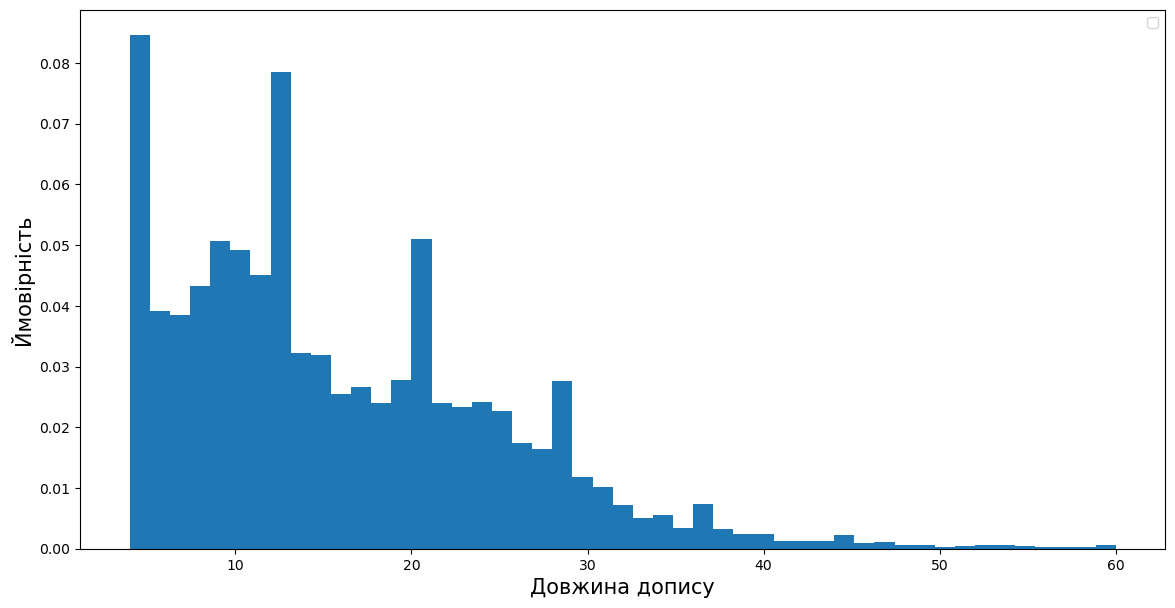

In [72]:
values = df["words_len"].values
bins = np.linspace(4, 60, 50)

fig = plt.figure(figsize = (14,7))
plt.hist(values, bins, density=True)
plt.xlabel("Довжина допису", fontsize=15)
plt.ylabel("Ймовірність", fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [73]:
df["words"] = df["processed_text"].apply(lambda text: text.split(" "))

In [74]:
sns.set()
plt.rcParams['figure.figsize'] = [15, 20]

In [75]:
def draw_word_cloud():
    wordcloud = WordCloud(background_color="white", contour_width=0.1, scale=1,
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2")
    for i, label_name in zip(range(10), np.unique(df['max_reactions_category'])):
        df_part = df[df['max_reactions_category'] == label_name]
        words = df_part['words']
        allwords = []
        for wordlist in words:
            allwords += wordlist

        mostcommon = FreqDist(allwords).most_common(100)

        wordcloud.generate(text=str(mostcommon))   
        plt.subplot(5, 2, i+1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(label_name, fontsize=15)
    plt.show()

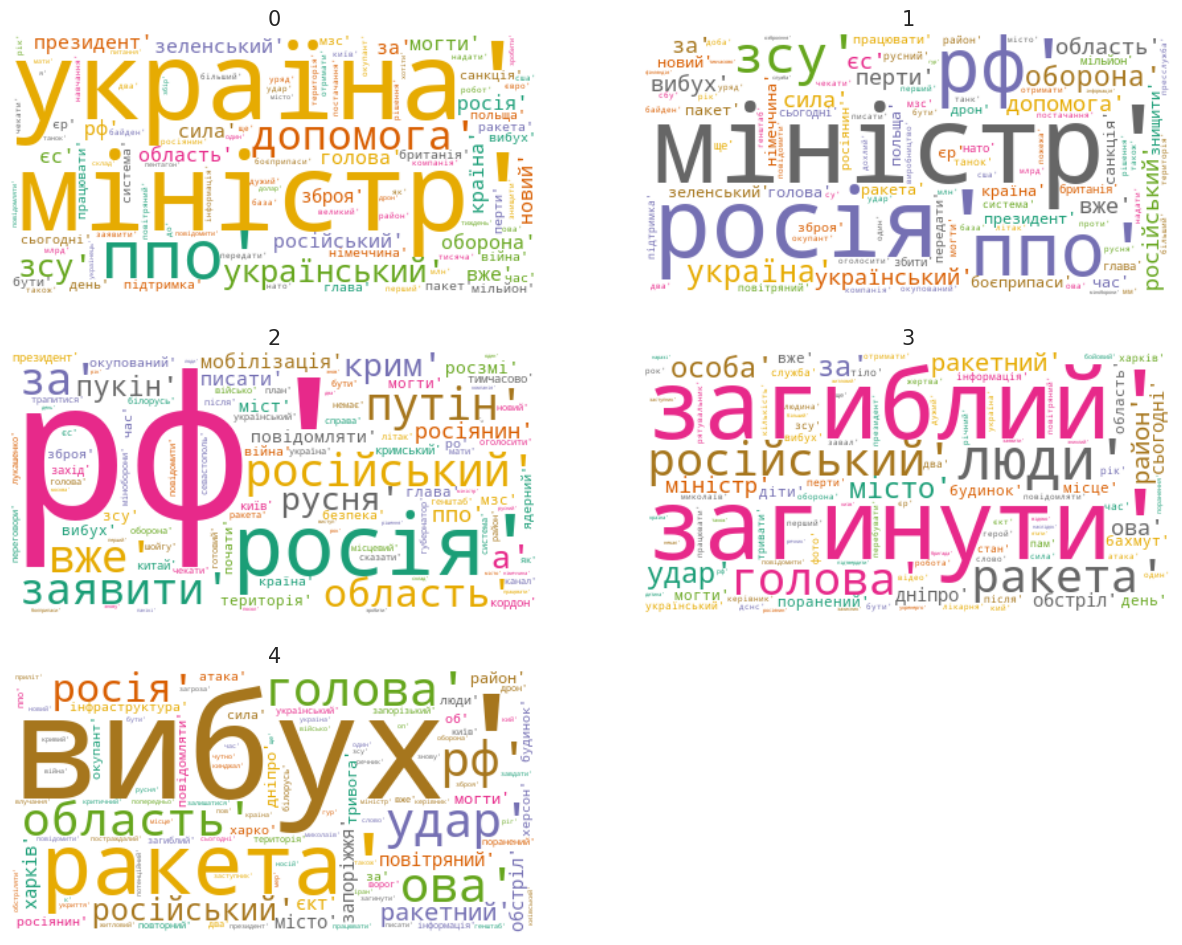

In [162]:
draw_word_cloud()

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">ID</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">Reaction</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">❤</span></th>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🔥</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😁</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😢</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🤬</span></td>
  </tr>
</tbody>
</table>

In [163]:
words_to_drop = ["до", "бути", "україна", "що", "про", "у", "в", "п", "сша", "військовий"]
# words_to_drop = []
def drop_words_by_hands(words):
    for word_to_drop in words_to_drop:
        if word_to_drop in words:
            words.remove(word_to_drop)
    return words

In [78]:
df["words"] = df["words"].apply(drop_words_by_hands)

In [79]:
df["words"]

11638    [тиждень, втратити, метр, земля, заявити, заст...
11447                                [нікополь, триматися]
4163     [ракетний, удар, окремий, територія, кіровогра...
4742                                                    []
10480    [явитися, можливість, включати, автоматично, с...
                               ...                        
3192     [сьогодні, василь, стус, могти, виповнитися, р...
8897                                                    []
3075     [слідкувати, за, ситуація, соледар, день, зара...
12631    [компанія, заявити, віддати, безпілотник, безк...
11025              [чекати, хотіти, побачити, фото, відео]
Name: words, Length: 11842, dtype: object

## Проектування ознак
На початку аналізу тексту, налаштуємо механізм вилучення ознак за методом n-gram

In [80]:
test_tokenization_message = "Гетьте думи ви хмари осінні"
words = nltk.word_tokenize(test_tokenization_message)

In [81]:
bigrams = nltk.ngrams(df["words"][2], n=2)

In [82]:
bigram_fdist = nltk.FreqDist(bigrams)

In [83]:
bigram_fdist.most_common(5)

[(('український', 'відбити'), 1),
 (('відбити', 'атака'), 1),
 (('атака', 'за'), 1),
 (('за', 'доба'), 1),
 (('доба', 'бахмутське'), 1)]

## Розділ вибірки на тренувальну, валідаційну та тестову
Розділ відбувається за такими правилами: 
* 20% - тестова вибірка
* 20% - валідаційна вибірка
* 60% - тренувальна вибірка

In [84]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)
df_train, df_val = train_test_split(df_train, test_size=0.25, train_size=0.75)

for tensorflow

In [85]:
df_train_tf, df_test_tf = train_test_split(df, test_size=0.2, train_size=0.8)

In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7104 entries, 8820 to 1303
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7104 non-null   int64  
 1   peer_id                 7104 non-null   int64  
 2   date                    7104 non-null   object 
 3   message                 7090 non-null   object 
 4   out                     7104 non-null   bool   
 5   mentioned               7104 non-null   bool   
 6   media_unread            7104 non-null   bool   
 7   silent                  7104 non-null   bool   
 8   post                    7104 non-null   bool   
 9   from_scheduled          7104 non-null   object 
 10  legacy                  7104 non-null   bool   
 11  pinned                  7104 non-null   object 
 12  fwd_from_channel        7104 non-null   object 
 13  fwd_from_message        7104 non-null   object 
 14  reply_to                7104 non-null

In [87]:
df_train.head(2)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,fwd_from_message,reply_to,views,forwards,reactions,processed_text,max_reaction,max_reactions_category,words,words_len
8820,19022,1536630827,"09/12/2022, 12:28:39","Японський уряд вніс зміни, щоб постачати Украї...",False,False,False,False,True,False,...,None,None,472665.0,1095.0,"{'❤': 27698, '🔥': 1315, '😁': 120, '😢': 47, '🤬'...",японський уряд внести зміна постачати україна ...,❤,0,"[японський, уряд, внести, зміна, постачати, во...",39
7121,20925,1536630827,"10/14/2022, 14:30:55",100 мільйонів гривень за 8 годин! Це як взага...,False,False,False,False,True,False,...,1003,None,464462.0,2266.0,"{'❤': 4869, '🔥': 36627, '😁': 156, '😢': 27, '🤬'...",мільйон гривня година взагалі називатися диво ...,🔥,1,"[мільйон, гривня, година, взагалі, називатися,...",25


# Перетворення тексту в нумерований формат
Для подальшого формування вхідного вектору моделі, дані будуть перетворені у нумерований формат.

## Bag-of-Words
Побудуємо словникову ознаку на основі N слів, що найчастіше зустрічаються.

In [88]:
word_counts = {}
def build_word_counts(words):
    for word in words:
        if word not in list(word_counts.keys()):
            word_counts[word] = 1
        word_counts[word] += 1

In [89]:
_ = df_train["words"].aggregate(build_word_counts)

Проведемо ранжування слів за частотою їх появ

In [90]:
words_by_freq = sorted(word_counts, key=word_counts.get, reverse=True)

words_to_index = {key: rank for rank, key in enumerate(words_by_freq, 0)}
index_to_words = {index: word for word, index in words_to_index.items()}

In [91]:
print("Розмір словника: ", len(words_by_freq), "\n", end="")
print("Топ-10", words_by_freq[:10])

Розмір словника:  11518 
Топ-10 ['вибух', 'рф', 'росія', 'російський', 'міністр', 'україна', 'за', 'голова', 'ппо', 'український']


### Побудова BOW
Для кожного допису створимо нульовий вектор з розмірністю N і заповнимо його відповідними словами, що зустрілися в цьому дописі

In [92]:
dict_size = len(words_by_freq)
def message_bow_vec(words, words_to_index):
    result_vec = np.zeros(dict_size)
    for word in words:
        if word in words_to_index:
            result_vec[words_to_index[word]] += 1
    return result_vec

In [93]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_val_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_val["words"]])
print("Train X shape -> ", X_train_bow.shape, "\nValidation X shape -> ", X_val_bow.shape)

Train X shape ->  (7104, 11518) 
Validation X shape ->  (2369, 11518)


In [94]:
X_train_bow_tf = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train_tf["words"]])
X_test_bow_tf = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_test_tf["words"]])

### TF-IDF
<i>Term frequency-inverse document frequency</i>

Ознака, мета якої відобразити наскільки важливе слово в документі в колекції корпусів тексту.
Цей метод є доповненням до Bag-of-Words, де частота слова поділена на загальну кількість слів. 

In [95]:
def tfidf_features_validation(X_train, X_val, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_val_tfidf = tfidf_vectorizer.transform(X_val["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [96]:
def tfidf_features(X_train, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

### N-gram
Врахуємо n-gram модель представлення частин тексту для подальшого інтелектуального аналізу тексту.
* рівень слів та словосполучень
* рівень символів кирилиці 

#### Рівень слів та словосполучень
Оберемо плаваючий розмір вікна 4(врахування усіх вікон від 1(рівень слова) до 4(словосполучення))
Застосуємо цей метод з припущенням, що в текстах дописів будуть присутні слова та словосполучення, що матимуть певну 

In [97]:
X_train_tfidf_w, X_val_tfidf_w, X_test_tfid_w, tfidf_vocab_w = tfidf_features_validation(df_train, df_val, df_test)

for tf

In [98]:
X_train_tfidf_w, X_test_tfidf_w, tfidf_vocab_w = tfidf_features(df_train_tf, df_test_tf)

In [99]:
tfidf_reversed_vocab_w = {i: word for word, i in tfidf_vocab_w.items()}

#### Тільки словосполучення

In [164]:
X_train_tfidf_wg, X_test_tfidf_wg, tfidf_vocab_wg = tfidf_features(
    df_train_tf, df_test_tf, (2,3), "word")

#### Символьний рівень
Оберемо вікно від 3(корінь слова) до 10

In [100]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,10), "char")

In [101]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train_tf, df_test_tf, (3,5), "char")

In [102]:
tfidf_reversed_vocab_c = {i: char_seq for char_seq, i in tfidf_vocab_c.items()}
len(tfidf_reversed_vocab_c)

46980

### Word2Vec

In [103]:
w2v = Word2Vec(df_train_tf["words"], vector_size=1000, window=3)
w2v.wv.index_to_key[:10]

['вибух',
 'рф',
 'російський',
 'росія',
 'україна',
 'міністр',
 'ппо',
 'український',
 'за',
 'зсу']

Переглянемо слова що більше за інші зустрічаються в контексті зі словом "росія" 

In [104]:
w2v.wv.most_similar("росія")

[('іран', 0.9996041059494019),
 ('більший', 0.9995541572570801),
 ('компанія', 0.9994258880615234),
 ('хотіти', 0.9993704557418823),
 ('рф', 0.9993597865104675),
 ('ятий', 0.9993420243263245),
 ('ядерний', 0.9992799758911133),
 ('постачання', 0.9992637038230896),
 ('список', 0.999237060546875),
 ('ввести', 0.9992369413375854)]

In [105]:
w2v_words = set(w2v.wv.index_to_key)
X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                        for corpus in df_train["words"]])
X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                       for corpus in df_test["words"]])

/tmp/ipykernel_16829/3204335971.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])
/tmp/ipykernel_16829/3204335971.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])


In [106]:
df_train["words"]

8820     [японський, уряд, внести, зміна, постачати, во...
7121     [мільйон, гривня, година, взагалі, називатися,...
6370     [антон, гура, спільник, олексій, оскер, люда, ...
10940                    [просити, ретвіт, тегат, твітера]
6288                [вибух, миколаївщина, попередньо, ппо]
                               ...                        
11173                                                   []
8799     [звільнити, майже, тисяча, квадратний, кіломет...
4709     [прокуратура, єс, готовий, розслідувати, ухиля...
1626     [ізраїль, надати, система, протиракетний, обор...
1303                            [росіянин, піти, росіянин]
Name: words, Length: 7104, dtype: object

In [107]:
X_train_w2v[0].shape

(34, 1000)

In [108]:
X_train_w2v[7].shape

(13, 1000)

In [109]:
def show_shape(X):    
    for i, v in enumerate(X):
        if i < 10:
            print(len(df_train["words"].iloc[i]), len(v))

In [110]:
X_train_w2v_avg = []
for word_vec in X_train_w2v:
    if word_vec.size:
        X_train_w2v_avg.append(word_vec.max(axis=0))
    else:
        X_train_w2v_avg.append(np.zeros(1000, dtype=float))
        
X_test_w2v_avg = []
for word_vec in X_test_w2v:
    if word_vec.size:
        X_test_w2v_avg.append(word_vec.mean(axis=0))
    else:
        X_test_w2v_avg.append(np.zeros(1000, dtype=float))

In [111]:
show_shape(X_train_w2v_avg)

36 1000
23 1000
14 1000
4 1000
4 1000
2 1000
18 1000
16 1000
23 1000
3 1000


In [112]:
show_shape(X_test_w2v_avg)

36 1000
23 1000
14 1000
4 1000
4 1000
2 1000
18 1000
16 1000
23 1000
3 1000


# Мульти-класова класифікація
Для побудови вирішення задачі класифікації буде використана сигмоїдна функція. Стратегія складається у побудові одного класифікатора для одного класу. Для кожного класифікатора клас порівнюється з усіма іншими класами.

In [113]:
def plot_learning_metrics(result, title):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(EPOCHS)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

In [114]:
OUT = len(reactions)
BATCH_SIZE = 64
EPOCHS = 15

In [115]:
def fit_learning_rate(model_function, l, train_data, model_name):
    (X_train, y_train) = train_data
    learning_rates = [10 ** (-i) for i in range(1, l+1)]
    
    for current_rate in learning_rates:
        model = model_function(learning_rate=current_rate)
        
        result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)
        
        print(f"learning rate -> {current_rate}")
        plot_learning_metrics(result, model_name)

## Одношаровий Softmax 
Архітектура моделі

In [116]:
def single_layer_softmax_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
        tf.keras.layers.Dense(OUT, 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), 
                              kernel_regularizer="l1",
                              activation="softmax")
    ])
    
    model.compile(# Adam + crossentropy
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [117]:
softmax_simple_bow = single_layer_softmax_model(X_train_bow_tf.toarray().shape)
softmax_simple_bow_result = softmax_simple_bow.fit(
    X_train_bow_tf.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.6095398664474487
Accuracy: 59.501% 



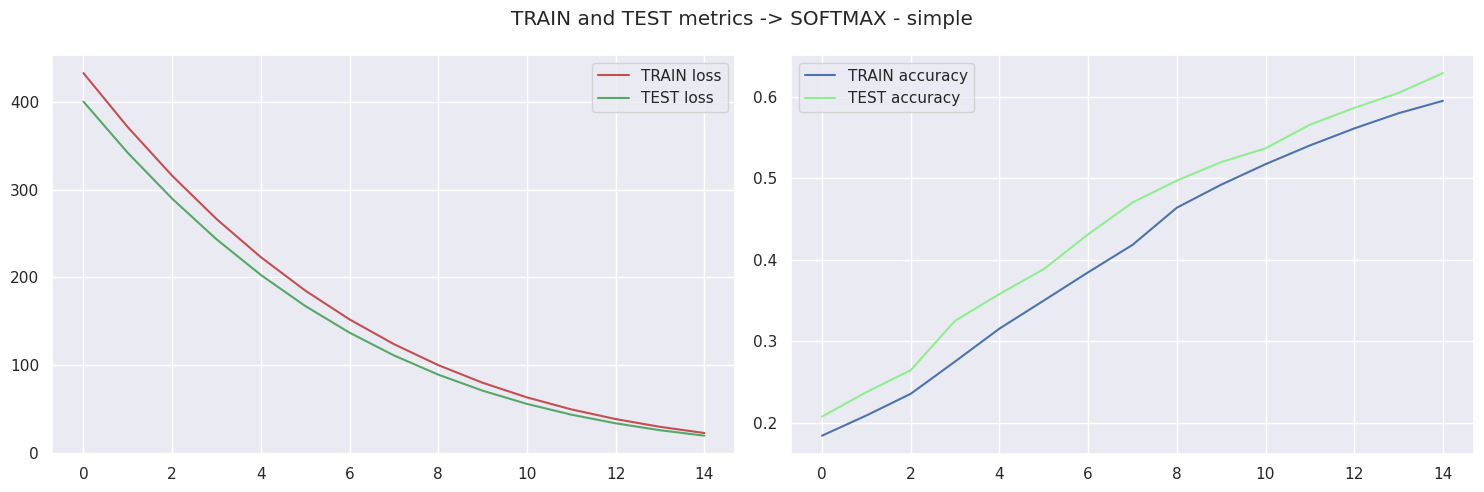

In [118]:
_, softmax_simple_accuracy = softmax_simple_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_bow_result, "SOFTMAX - simple")

### TF-IDF words n-gram sequences

In [119]:
softmax_simple_tfidf_w = single_layer_softmax_model(X_train_tfidf_w.toarray().shape)
softmax_simple_tfidf_w_result = softmax_simple_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.5854790806770325
Accuracy: 59.554% 



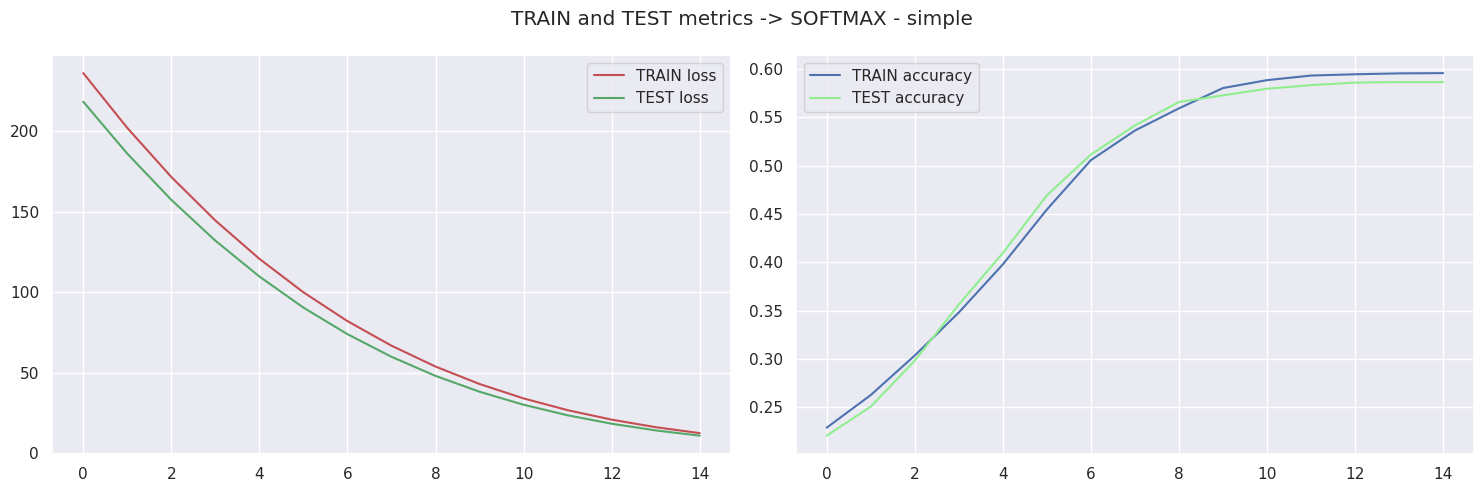

In [120]:
_, softmax_simple_accuracy = softmax_simple_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_tfidf_w_result, "SOFTMAX - simple")

### TF-IDF char n-grams

In [121]:
softmax_simple_tfidf_c = single_layer_softmax_model(X_train_tfidf_c.toarray().shape)
softmax_simple_tfidf_c_result = softmax_simple_tfidf_c.fit(
    X_train_tfidf_c.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

2023-05-01 01:22:42.314452: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1424057760 exceeds 10% of free system memory.


SIMPLE SOFTMAX
On TEST accuracy: 0.5859012007713318
Accuracy: 59.567% 



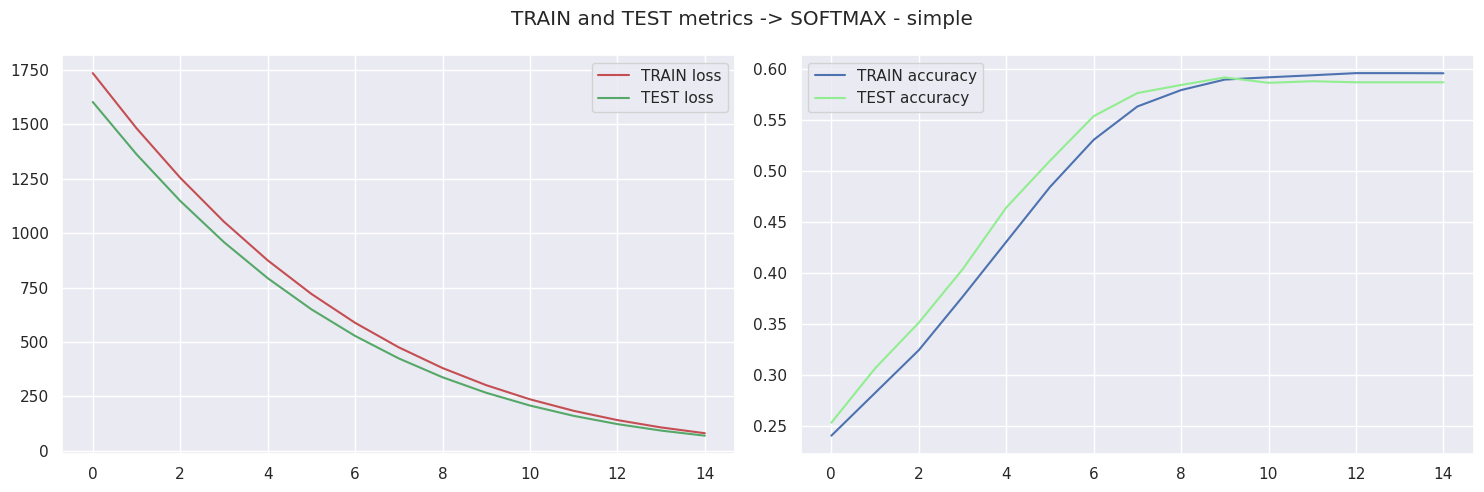

In [122]:
_, softmax_simple_accuracy = softmax_simple_tfidf_c.evaluate(X_test_tfidf_c.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_tfidf_c_result, "SOFTMAX - simple")

### Word2Vec

In [124]:
softmax_simple_w2v = single_layer_softmax_model(np.array(X_train_w2v_avg).shape)
softmax_simple_w2v_result = softmax_simple_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.5829464197158813
Accuracy: 58.895% 



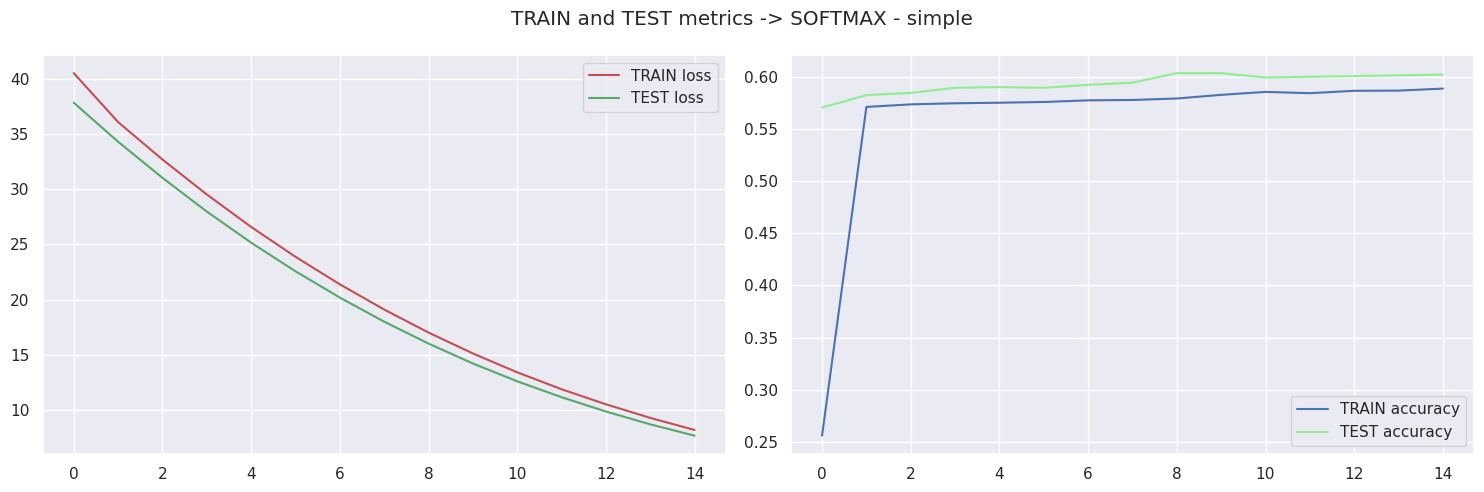

In [125]:
_, softmax_simple_accuracy = softmax_simple_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_w2v_result, "SOFTMAX - simple")

## Multi-layer deep neural network

In [126]:
def deep_multilayer_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
        tf.keras.layers.Dense(512,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0),
                              kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(# Adam + crossentropy
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [127]:
multi_layer_bow = deep_multilayer_model(X_train_bow_tf.toarray().shape)
multi_layer_bow_result = multi_layer_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]
On TEST accuracy: 0.6411988139152527
Accuracy: 87.794% 



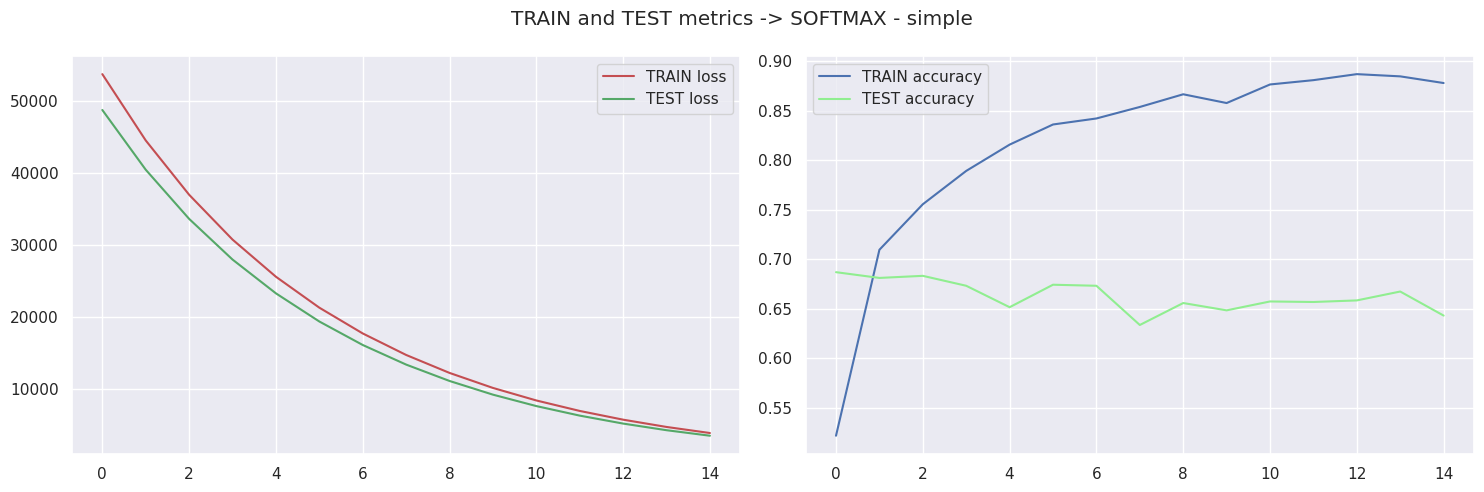

In [128]:
_, multi_layer_bow_accuracy = multi_layer_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]")
print(f"On TEST accuracy: {multi_layer_bow_accuracy}")
plot_learning_metrics(multi_layer_bow_result, "SOFTMAX - simple")

### Word2Vec

In [131]:
multi_layer_w2v = deep_multilayer_model(np.array(X_train_w2v_avg).shape)
multi_layer_w2v_result = multi_layer_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.5719712972640991
Accuracy: 58.455% 



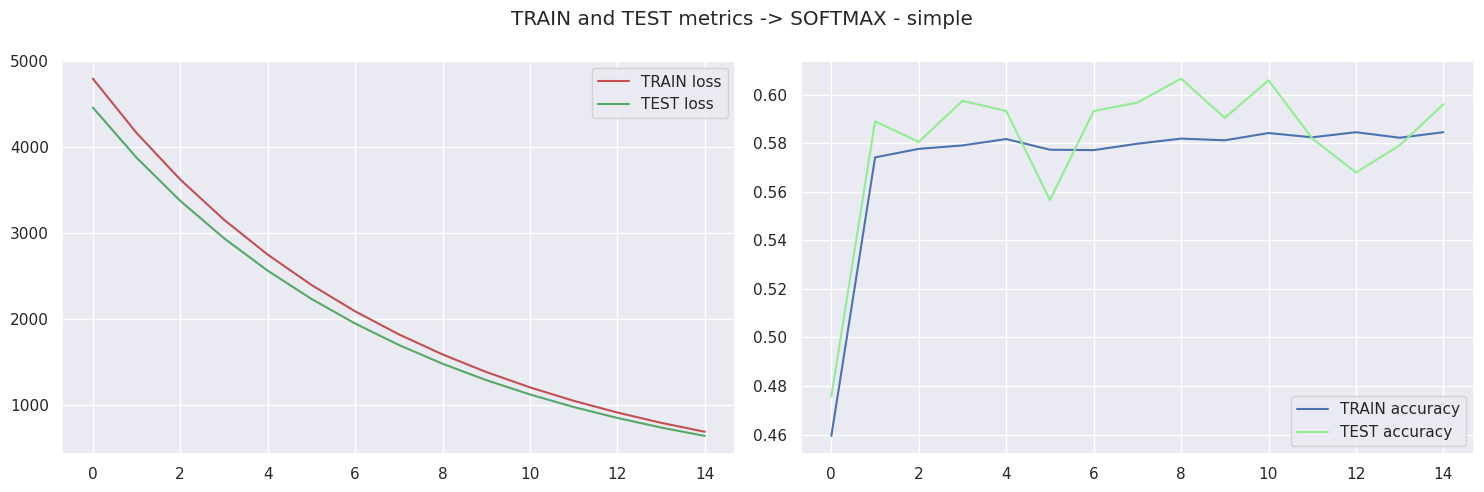

In [132]:
_, multi_layer_w2v_accuracy = multi_layer_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {multi_layer_w2v_accuracy}")
plot_learning_metrics(multi_layer_w2v_result, "SOFTMAX - simple")

## Multi-layer model with dropout regularization

In [133]:
def deep_multilayer_with_dropout_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

### BOW

In [134]:
multi_layer_dropout_bow = deep_multilayer_with_dropout_model(X_train_bow_tf.toarray().shape)
multi_layer_dropout_bow_result = multi_layer_dropout_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

MULTILAYER WITH DROPOUT - BOW
On TEST accuracy: 0.5082313418388367
Accuracy: 81.024% 



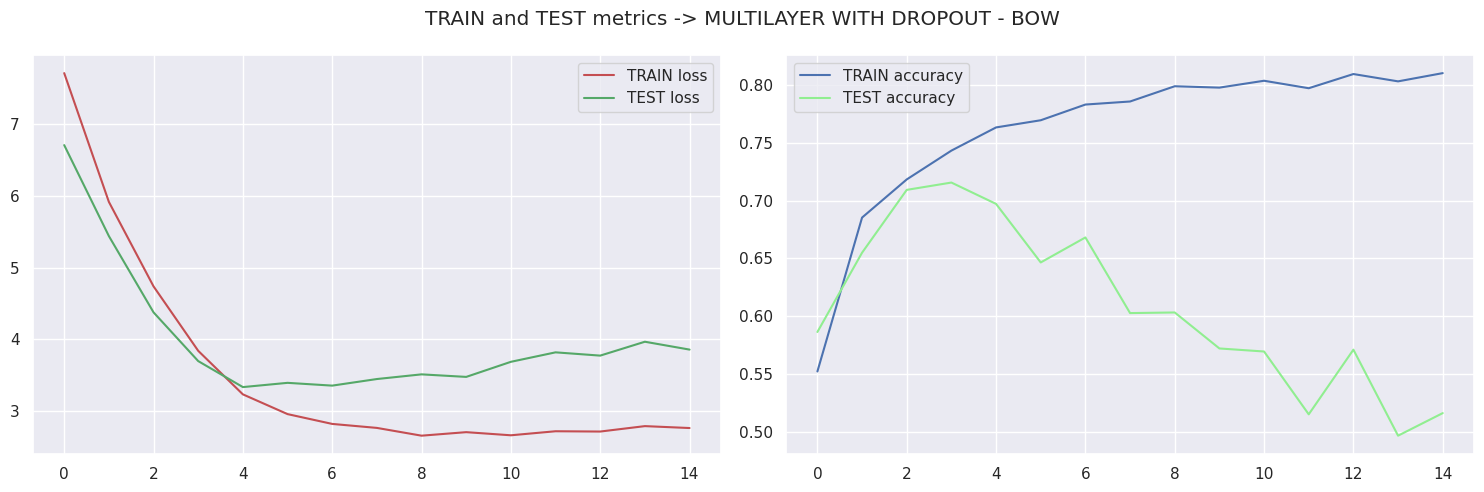

In [135]:
_, multi_layer_dropout_bow_accuracy = multi_layer_dropout_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER WITH DROPOUT - BOW")
print(f"On TEST accuracy: {multi_layer_dropout_bow_accuracy}")
plot_learning_metrics(multi_layer_dropout_bow_result, "MULTILAYER WITH DROPOUT - BOW")

### TF-IDF

In [175]:
multi_layer_dropout_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape, learning_rate=0.0001)
multi_layer_dropout_tfidf_wg_result = multi_layer_dropout_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 2s 10ms/step - loss: 14.3087 - accuracy: 0.2004 - val_loss: 12.7095 - val_accuracy: 0.2248
Epoch 2/15
119/119 [==============================] - 1s 11ms/step - loss: 12.3371 - accuracy: 0.3183 - val_loss: 11.4789 - val_accuracy: 0.5599
Epoch 3/15
119/119 [==============================] - 1s 11ms/step - loss: 11.2828 - accuracy: 0.4339 - val_loss: 10.7228 - val_accuracy: 0.5937
Epoch 4/15
119/119 [==============================] - 1s 11ms/step - loss: 10.5719 - accuracy: 0.4955 - val_loss: 10.1642 - val_accuracy: 0.5916
Epoch 5/15
119/119 [==============================] - 1s 11ms/step - loss: 10.0134 - accuracy: 0.5153 - val_loss: 9.6193 - val_accuracy: 0.6142
Epoch 6/15
119/119 [==============================] - 1s 11ms/step - loss: 9.5328 - accuracy: 0.5447 - val_loss: 9.1417 - val_accuracy: 0.6317
Epoch 7/15
119/119 [==============================] - 1s 11ms/step - loss: 9.1076 - accuracy: 0.5458 - val_loss: 8.7586 - val_accurac

TF-IDF with DROPOUT
On TEST accuracy: 0.6661038398742676
Accuracy: 63.777% 



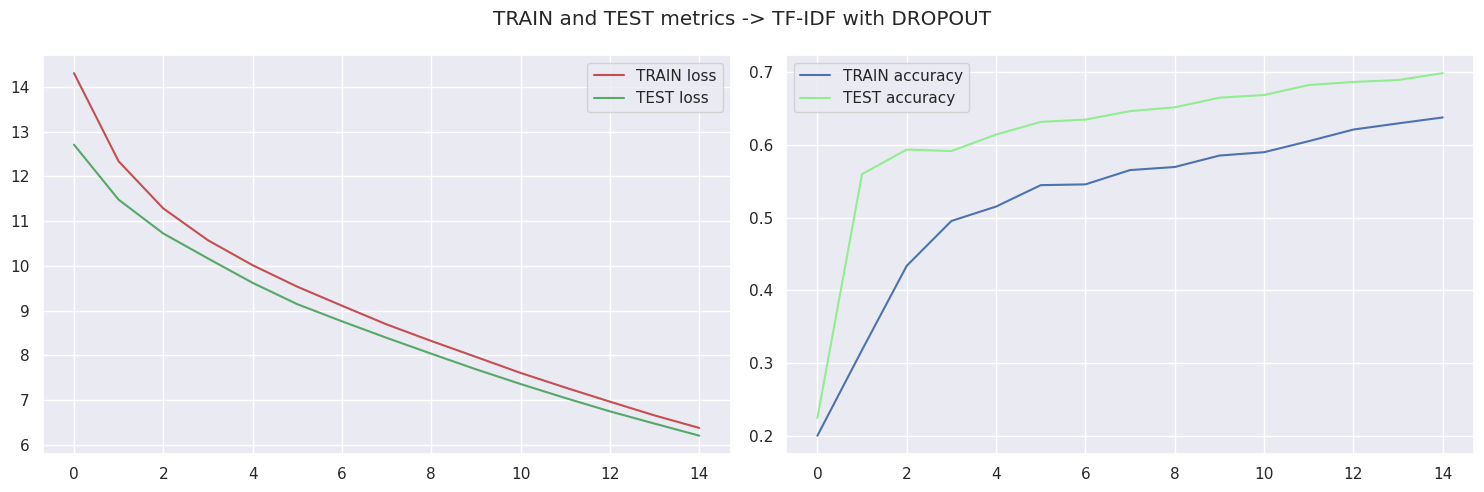

In [176]:
_, multi_layer_dropout_tfidf_wg_accuracy = multi_layer_dropout_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_wg_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_wg_result, "TF-IDF with DROPOUT")

#### Усі групи слів

In [136]:
multi_layer_dropout_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

TF-IDF with DROPOUT
On TEST accuracy: 0.6618826389312744
Accuracy: 79.124% 



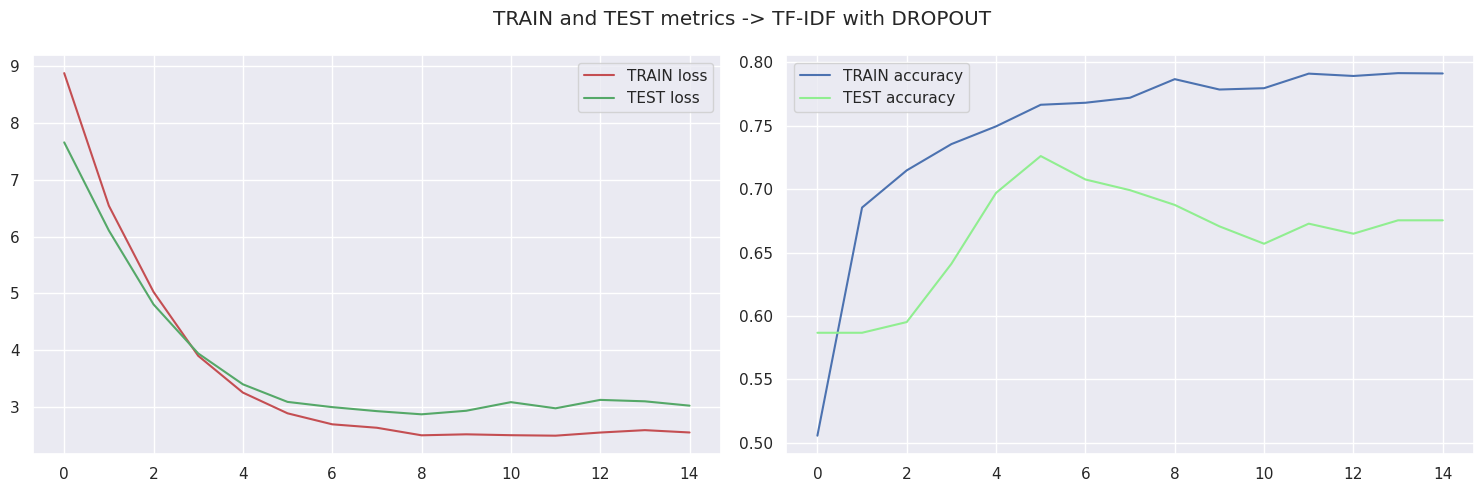

In [137]:
_, multi_layer_dropout_tfidf_w_accuracy = multi_layer_dropout_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_w_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_w_result, "TF-IDF with DROPOUT")

### Word2Vec

In [138]:
multi_layer_dropout_w2v = deep_multilayer_with_dropout_model(np.array(X_train_w2v_avg).shape)
multi_layer_dropout_w2v_result = multi_layer_dropout_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

MULTILAYER WITH DROPOUT - Word2Vec
On TEST accuracy: 0.5859012007713318
Accuracy: 59.071% 



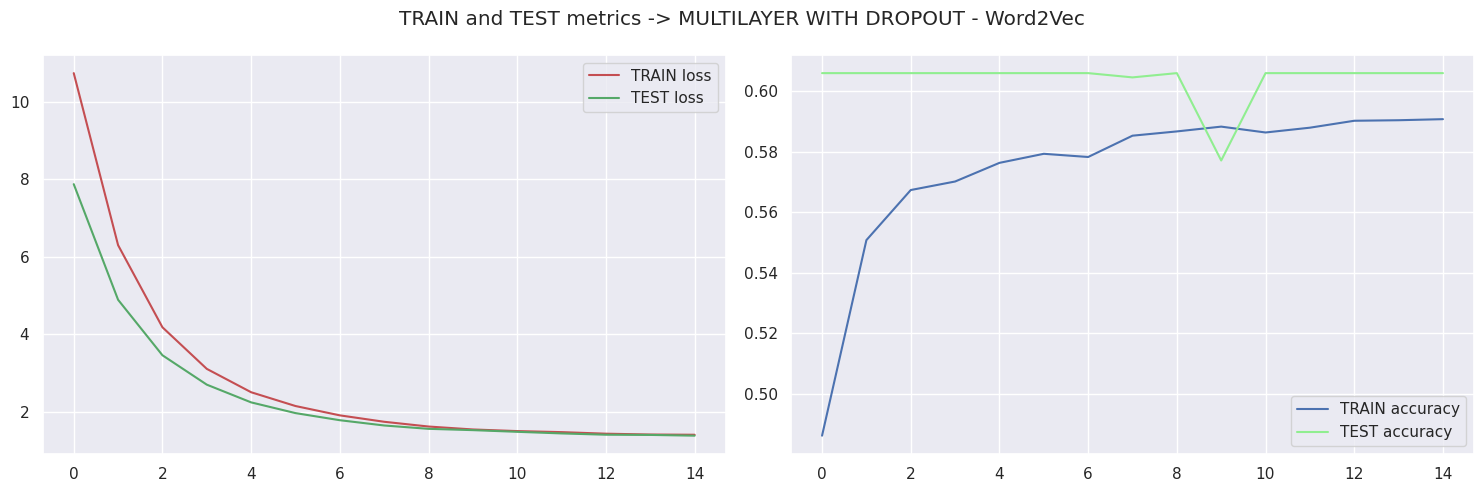

In [139]:
_, multi_layer_dropout_w2v_accuracy = multi_layer_dropout_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER WITH DROPOUT - Word2Vec")
print(f"On TEST accuracy: {multi_layer_dropout_w2v_accuracy}")
plot_learning_metrics(multi_layer_dropout_w2v_result, "MULTILAYER WITH DROPOUT - Word2Vec")

## Multi-layer with dropout and early stopping

In [ ]:
def multi_layer_with_dropout_early_stopping(input_shape, learning_rate=0.001):
    model = deep_multilayer_with_dropout_model(input_shape, learning_rate)
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0.2)
    
    return model, callback

In [ ]:
multi_layer_dropout_tfidf_w, callback = multi_layer_with_dropout_early_stopping(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

In [ ]:
_, multi_layer_dropout_tfidf_w_accuracy = multi_layer_dropout_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_w_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_w_result, "TF-IDF with DROPOUT")

## Deep CNN

In [152]:
def deep_cnn_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.Conv1D(512, 3, activation="relu", padding="same", input_shape=(input_shape[1],1)),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(256, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.AveragePooling1D(pool_size=3, padding="same"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

## BOW

In [157]:
deep_cnn_bow = deep_multilayer_with_dropout_model(X_train_bow_tf.toarray().shape)
deep_cnn_bow_result = deep_cnn_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

Epoch 1/15
119/119 [==============================] - 4s 28ms/step - loss: 7.6430 - accuracy: 0.5867 - val_loss: 6.7376 - val_accuracy: 0.5858
Epoch 2/15
119/119 [==============================] - 3s 28ms/step - loss: 5.9046 - accuracy: 0.6895 - val_loss: 5.4011 - val_accuracy: 0.6802
Epoch 3/15
119/119 [==============================] - 4s 30ms/step - loss: 4.6700 - accuracy: 0.7213 - val_loss: 4.2951 - val_accuracy: 0.7208
Epoch 4/15
119/119 [==============================] - 3s 26ms/step - loss: 3.7909 - accuracy: 0.7406 - val_loss: 3.6469 - val_accuracy: 0.7193
Epoch 5/15
119/119 [==============================] - 3s 27ms/step - loss: 3.2545 - accuracy: 0.7515 - val_loss: 3.3529 - val_accuracy: 0.6913
Epoch 6/15
119/119 [==============================] - 3s 28ms/step - loss: 2.8858 - accuracy: 0.7720 - val_loss: 3.2443 - val_accuracy: 0.6702
Epoch 7/15
119/119 [==============================] - 3s 27ms/step - loss: 2.7661 - accuracy: 0.7816 - val_loss: 3.3130 - val_accuracy: 0.6306

CNN - BOW
On TEST accuracy: 0.5647952556610107
Accuracy: 80.958% 



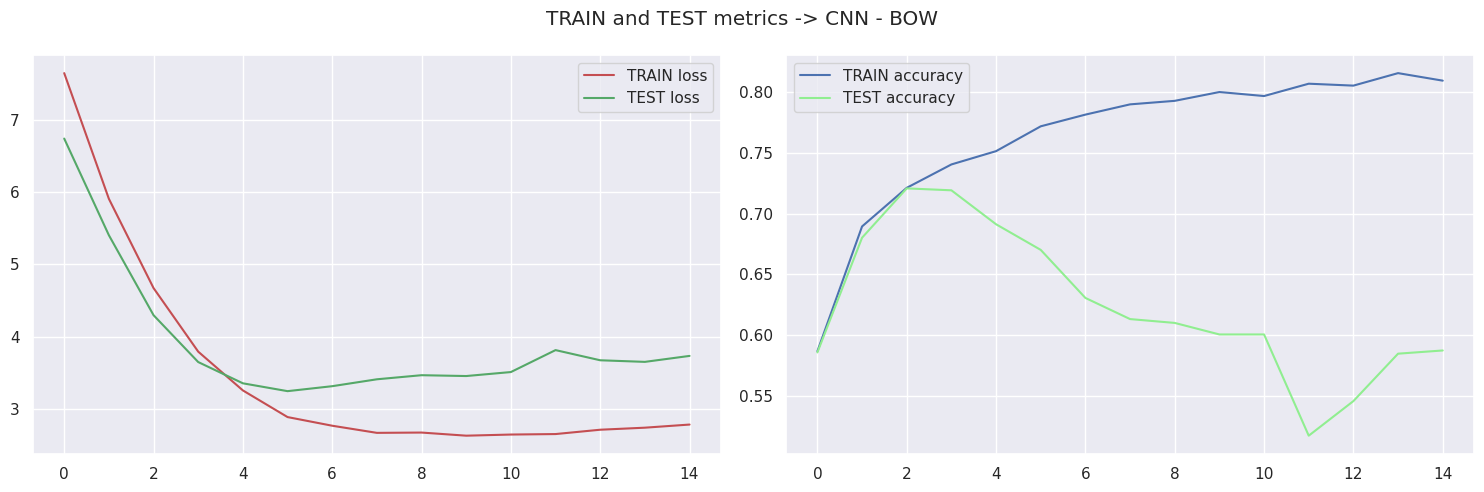

In [158]:
_, deep_cnn_bow_accuracy = deep_cnn_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - BOW")
print(f"On TEST accuracy: {deep_cnn_bow_accuracy}")
plot_learning_metrics(deep_cnn_bow_result, "CNN - BOW")

### TF-IDF

#### Тільки словосполучення

In [165]:
deep_cnn_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape)
deep_cnn_tfidf_wg_result = deep_cnn_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 2s 11ms/step - loss: 8.0379 - accuracy: 0.5264 - val_loss: 6.2810 - val_accuracy: 0.5868
Epoch 2/15
119/119 [==============================] - 1s 11ms/step - loss: 5.4236 - accuracy: 0.6324 - val_loss: 4.8466 - val_accuracy: 0.5873
Epoch 3/15
119/119 [==============================] - 1s 11ms/step - loss: 4.1978 - accuracy: 0.6681 - val_loss: 3.7933 - val_accuracy: 0.6285
Epoch 4/15
119/119 [==============================] - 1s 11ms/step - loss: 3.3118 - accuracy: 0.6900 - val_loss: 3.0182 - val_accuracy: 0.6902
Epoch 5/15
119/119 [==============================] - 1s 11ms/step - loss: 2.7103 - accuracy: 0.6950 - val_loss: 2.5504 - val_accuracy: 0.6950
Epoch 6/15
119/119 [==============================] - 1s 11ms/step - loss: 2.3604 - accuracy: 0.7022 - val_loss: 2.3004 - val_accuracy: 0.6860
Epoch 7/15
119/119 [==============================] - 1s 11ms/step - loss: 2.1217 - accuracy: 0.7003 - val_loss: 2.1792 - val_accuracy: 0.6844

CNN - TF-IDF WG
On TEST accuracy: 0.64288729429245
Accuracy: 70.876% 



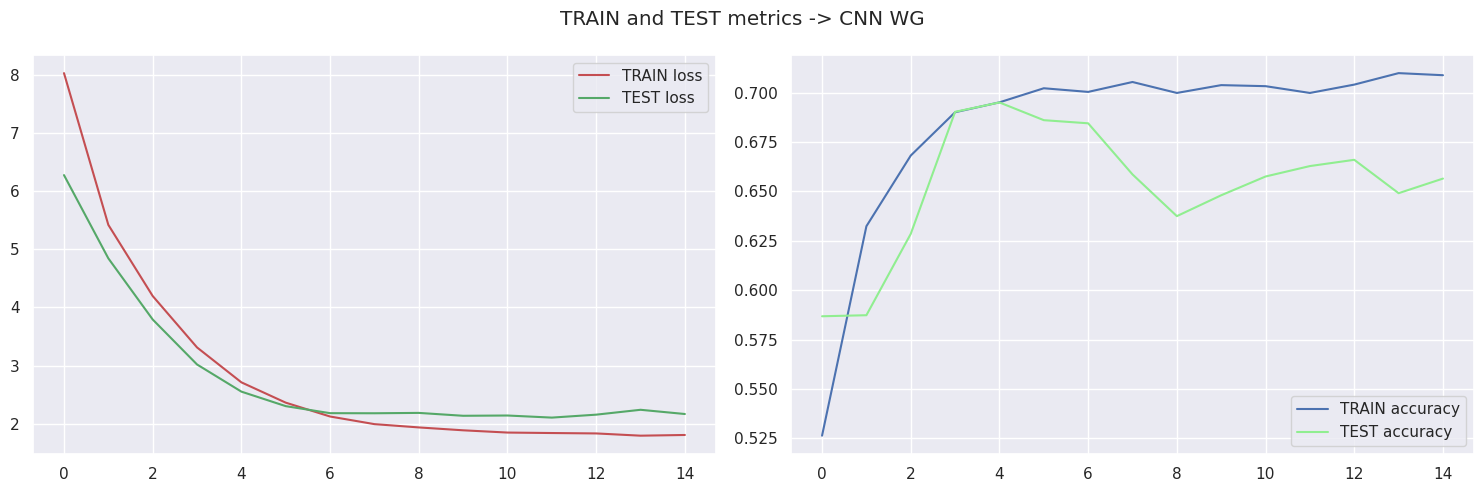

In [166]:
_, deep_cnn_tfidf_wg_accuracy = deep_cnn_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF WG")
print(f"On TEST accuracy: {deep_cnn_tfidf_wg_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_wg_result, "CNN WG")

#### Усі групи слів

In [160]:
deep_cnn_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
deep_cnn_tfidf_w_result = deep_cnn_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 4s 17ms/step - loss: 8.6814 - accuracy: 0.5640 - val_loss: 7.5311 - val_accuracy: 0.5868
Epoch 2/15
119/119 [==============================] - 2s 17ms/step - loss: 6.5145 - accuracy: 0.6832 - val_loss: 5.9981 - val_accuracy: 0.5905
Epoch 3/15
119/119 [==============================] - 2s 16ms/step - loss: 5.0191 - accuracy: 0.7167 - val_loss: 4.7872 - val_accuracy: 0.6016
Epoch 4/15
119/119 [==============================] - 2s 17ms/step - loss: 3.9599 - accuracy: 0.7357 - val_loss: 4.0127 - val_accuracy: 0.6237
Epoch 5/15
119/119 [==============================] - 2s 17ms/step - loss: 3.3099 - accuracy: 0.7420 - val_loss: 3.4086 - val_accuracy: 0.6908
Epoch 6/15
119/119 [==============================] - 2s 16ms/step - loss: 2.9215 - accuracy: 0.7625 - val_loss: 3.0666 - val_accuracy: 0.7140
Epoch 7/15
119/119 [==============================] - 2s 17ms/step - loss: 2.7191 - accuracy: 0.7629 - val_loss: 3.0400 - val_accuracy: 0.6982

CNN - TF-IDF
On TEST accuracy: 0.6234698295593262
Accuracy: 79.44% 



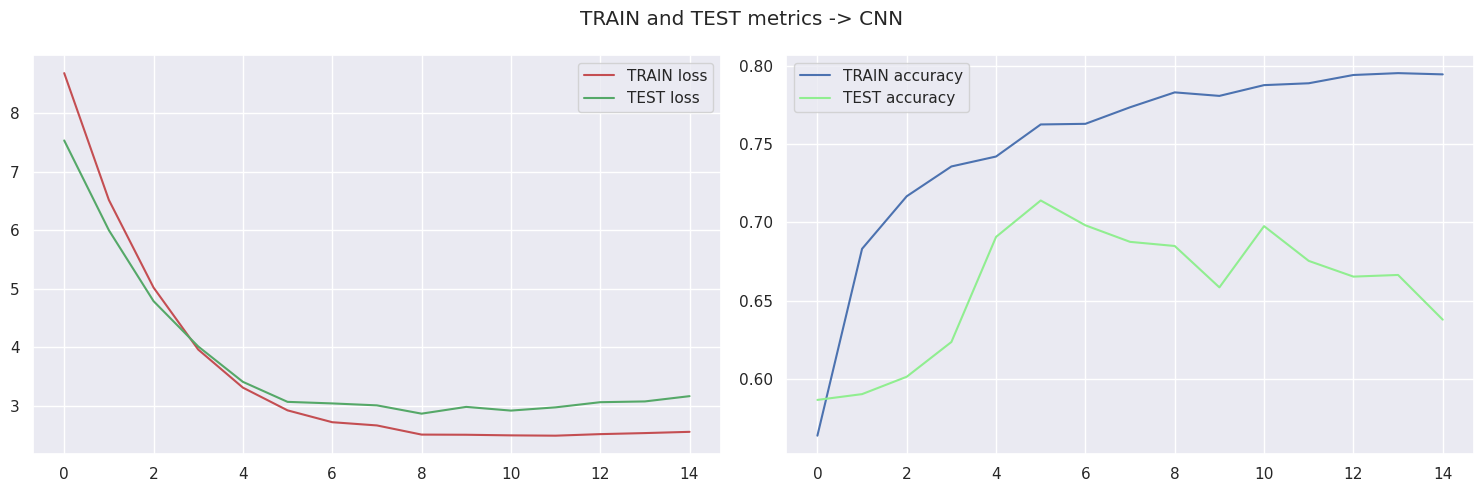

In [161]:
_, deep_cnn_tfidf_w_accuracy = deep_cnn_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF")
print(f"On TEST accuracy: {deep_cnn_tfidf_w_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_w_result, "CNN")

### Word2vec

In [155]:
deep_cnn_w2v = deep_cnn_model(np.array(X_train_w2v_avg).shape, learning_rate=0.00001)
deep_cnn_w2v_result = deep_cnn_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
89/89 [==============================] - 41s 444ms/step - loss: 1.6353 - accuracy: 0.3190 - val_loss: 1.6807 - val_accuracy: 0.0401
Epoch 2/15
89/89 [==============================] - 40s 444ms/step - loss: 1.4688 - accuracy: 0.4213 - val_loss: 1.5644 - val_accuracy: 0.1928
Epoch 3/15
89/89 [==============================] - 39s 442ms/step - loss: 1.3727 - accuracy: 0.4916 - val_loss: 1.4996 - val_accuracy: 0.2864
Epoch 4/15
89/89 [==============================] - 40s 446ms/step - loss: 1.3348 - accuracy: 0.5214 - val_loss: 1.4744 - val_accuracy: 0.2709
Epoch 5/15
89/89 [==============================] - 40s 446ms/step - loss: 1.2872 - accuracy: 0.5480 - val_loss: 1.4019 - val_accuracy: 0.3610
Epoch 6/15
89/89 [==============================] - 40s 447ms/step - loss: 1.2578 - accuracy: 0.5601 - val_loss: 1.3548 - val_accuracy: 0.4553
Epoch 7/15
89/89 [==============================] - 40s 445ms/step - loss: 1.2546 - accuracy: 0.5582 - val_loss: 1.3017 - val_accuracy: 0.4166

MULTILAYER CNN - Word2Vec
On TEST accuracy: 0.5859012007713318
Accuracy: 57.874% 



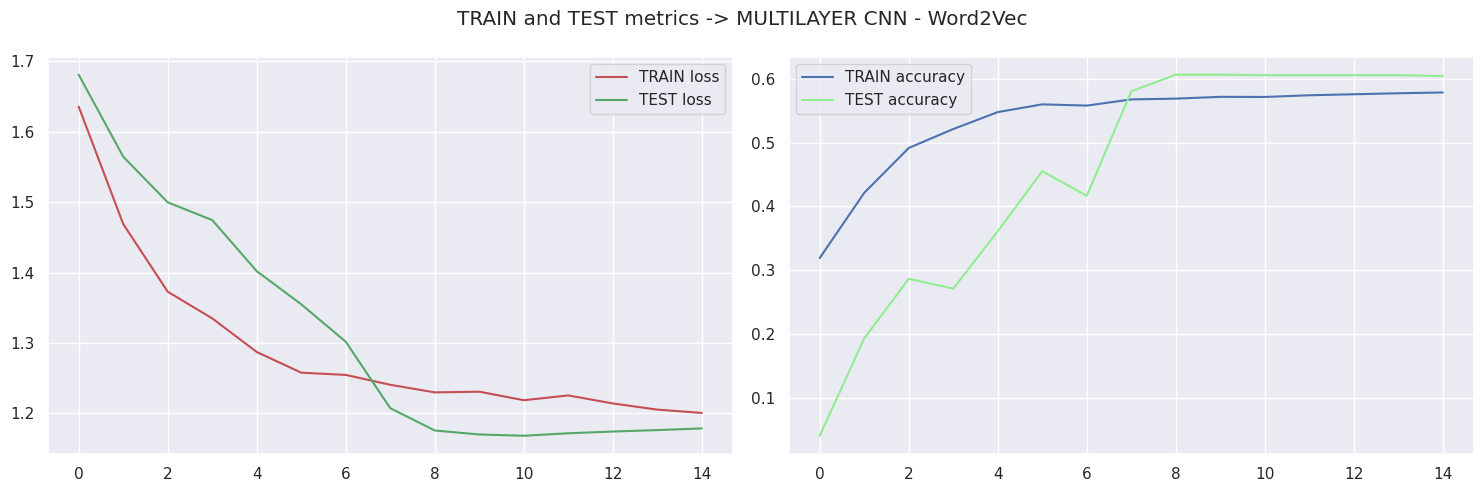

In [156]:
_, deep_cnn_w2v_accuracy = deep_cnn_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER CNN - Word2Vec")
print(f"On TEST accuracy: {deep_cnn_w2v_accuracy}")
plot_learning_metrics(deep_cnn_w2v_result, "MULTILAYER CNN - Word2Vec")

# Аналіз отриманих результатів
Зняття отриманих метрик та проведення аналізу отриманого результату

In [ ]:
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    
#     f1 = f1_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    
#     precision = precision_score(y_true, y_pred)
#     precision_macro = average_precision_score(y_true, y_pred, average="macro")
#     precision_micro = average_precision_score(y_true, y_pred, average="micro")
#     precision_weighted = average_precision_score(y_true, y_pred, average="weighted")
    
    recall = recall_score(y_true, y_pred, average="macro")
    
#     fpr, fnr, thresholds = det_curve(y_true, y_pred, pos_label=int)
    
    return {
        "accuracy": accuracy,
#         "f1": f1,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted,
#         "precision": precision,
#         "precision_macro": precision_macro,
#         "precision_micro": precision_micro,
#         "precision_weighted": precision_weighted,
#         "recall": recall,
#         "fpr": fpr, # False Acceptance Rate
#         "fnr": fnr # False Rejection Rate
    }

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_bow)

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_tfidf_w)

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_tfidf_c)